## Graph model selection outputs

In [21]:
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt

def get_substring_before(ds_string, keyword):
    index = ds_string.find(keyword)
    if index != -1:
        substring = ds_string[:index]
    else:
        substring = ds_string  # If '_transformed' is not found
    return substring


def load_model_selection(filename):

    df = pd.read_json(filename)  # or however you load your DataFrame
    # Create relplot
    df['model_shortname'] = df['model'].apply(lambda x: x[-17:-4])
    df['domain'] = df['source'].apply(lambda x: "source" if x else "target")
    df['dataset_og'] = df['dataset'].apply(lambda x: x[4:-3])
    df['dataset_og'] = df['dataset_og'].apply(lambda x: get_substring_before(x, '_transformed'))
    df['dataset_og'] = df['dataset_og'].apply(lambda x: get_substring_before(x, '_sample'))
    df['loss_box_giou_diff'] = 1-df['loss_box_giou']
    
    return df


run = "cityscapes_baseline_strongaug_ema" #"sim10k_baseline_strongaug_ema" #"mt_inf_sq" , "aldi_inf_udd" "base_strongaug_ema_inf_sq" "aldi_inf_sq"
outputs_filename = f"/home/heather/GitHub/aldi0107/outputs/cityscapes/{run}/model_selection/model_selection.json"
df = load_model_selection(outputs_filename)
 


In [22]:
if False:
    outputs_transform_filename = f"/home/heather/GitHub/aldi0107/outputs/urchininf/{run}/model_selection/model_selection.json"
    df_transform = load_model_selection(outputs_transform_filename)
    df = pd.concat([df, df_transform[df_transform['source']]])

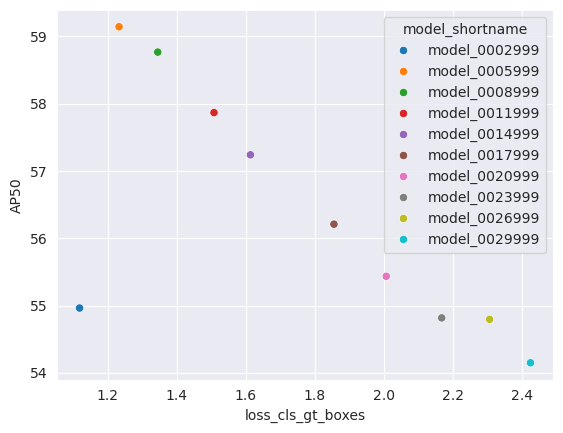

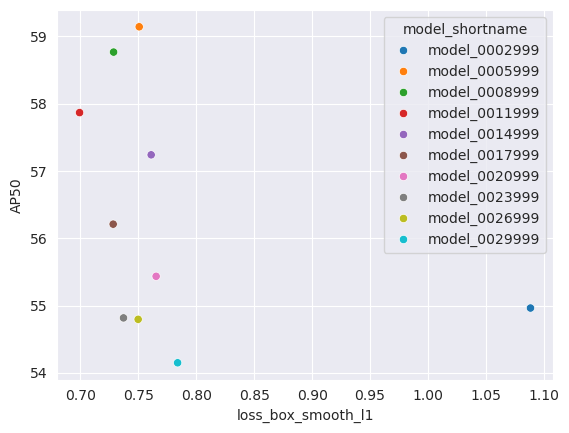

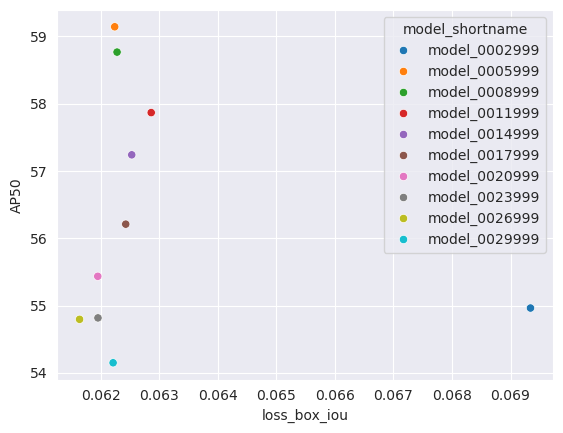

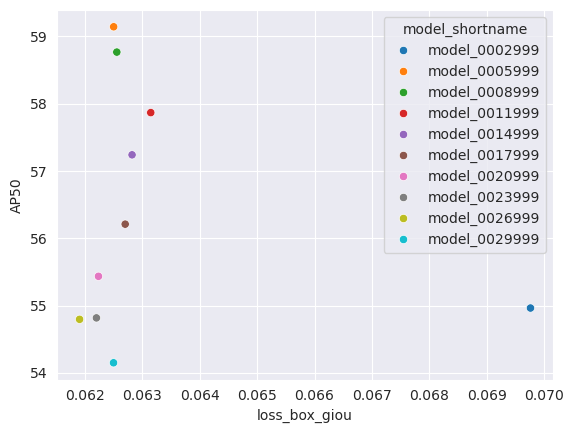

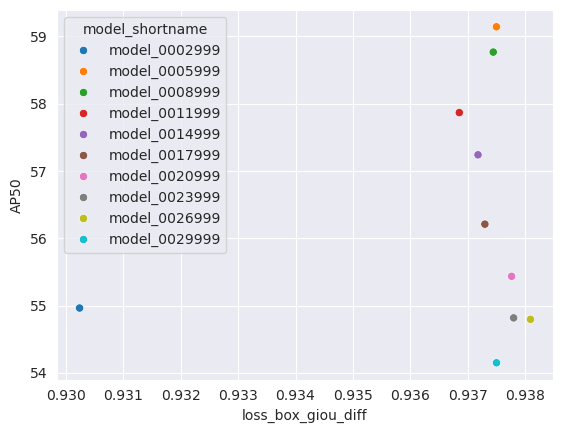

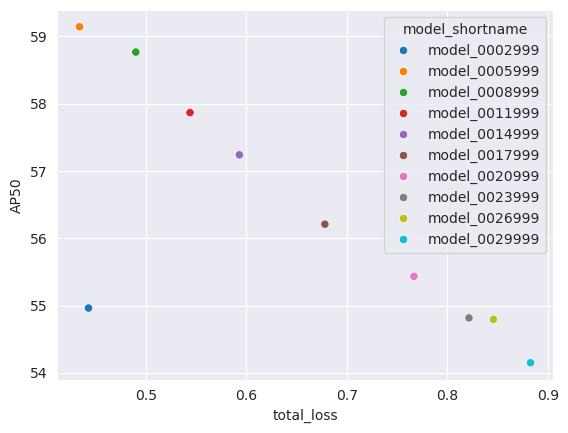

In [38]:

factors =  ['loss_cls_gt_boxes', 'loss_box_smooth_l1', 'loss_box_iou', 'loss_box_giou', 'loss_box_giou_diff', 'total_loss' ]
cls_factor = factors[0]
box_factor = factors[3]

#factors = [cls_factor, box_factor]
eval = 'AP50'

for f in factors:
    sns.scatterplot(data=df, x=f, y=eval, hue='model_shortname')
    plt.show()

# Show plot
plt.show()

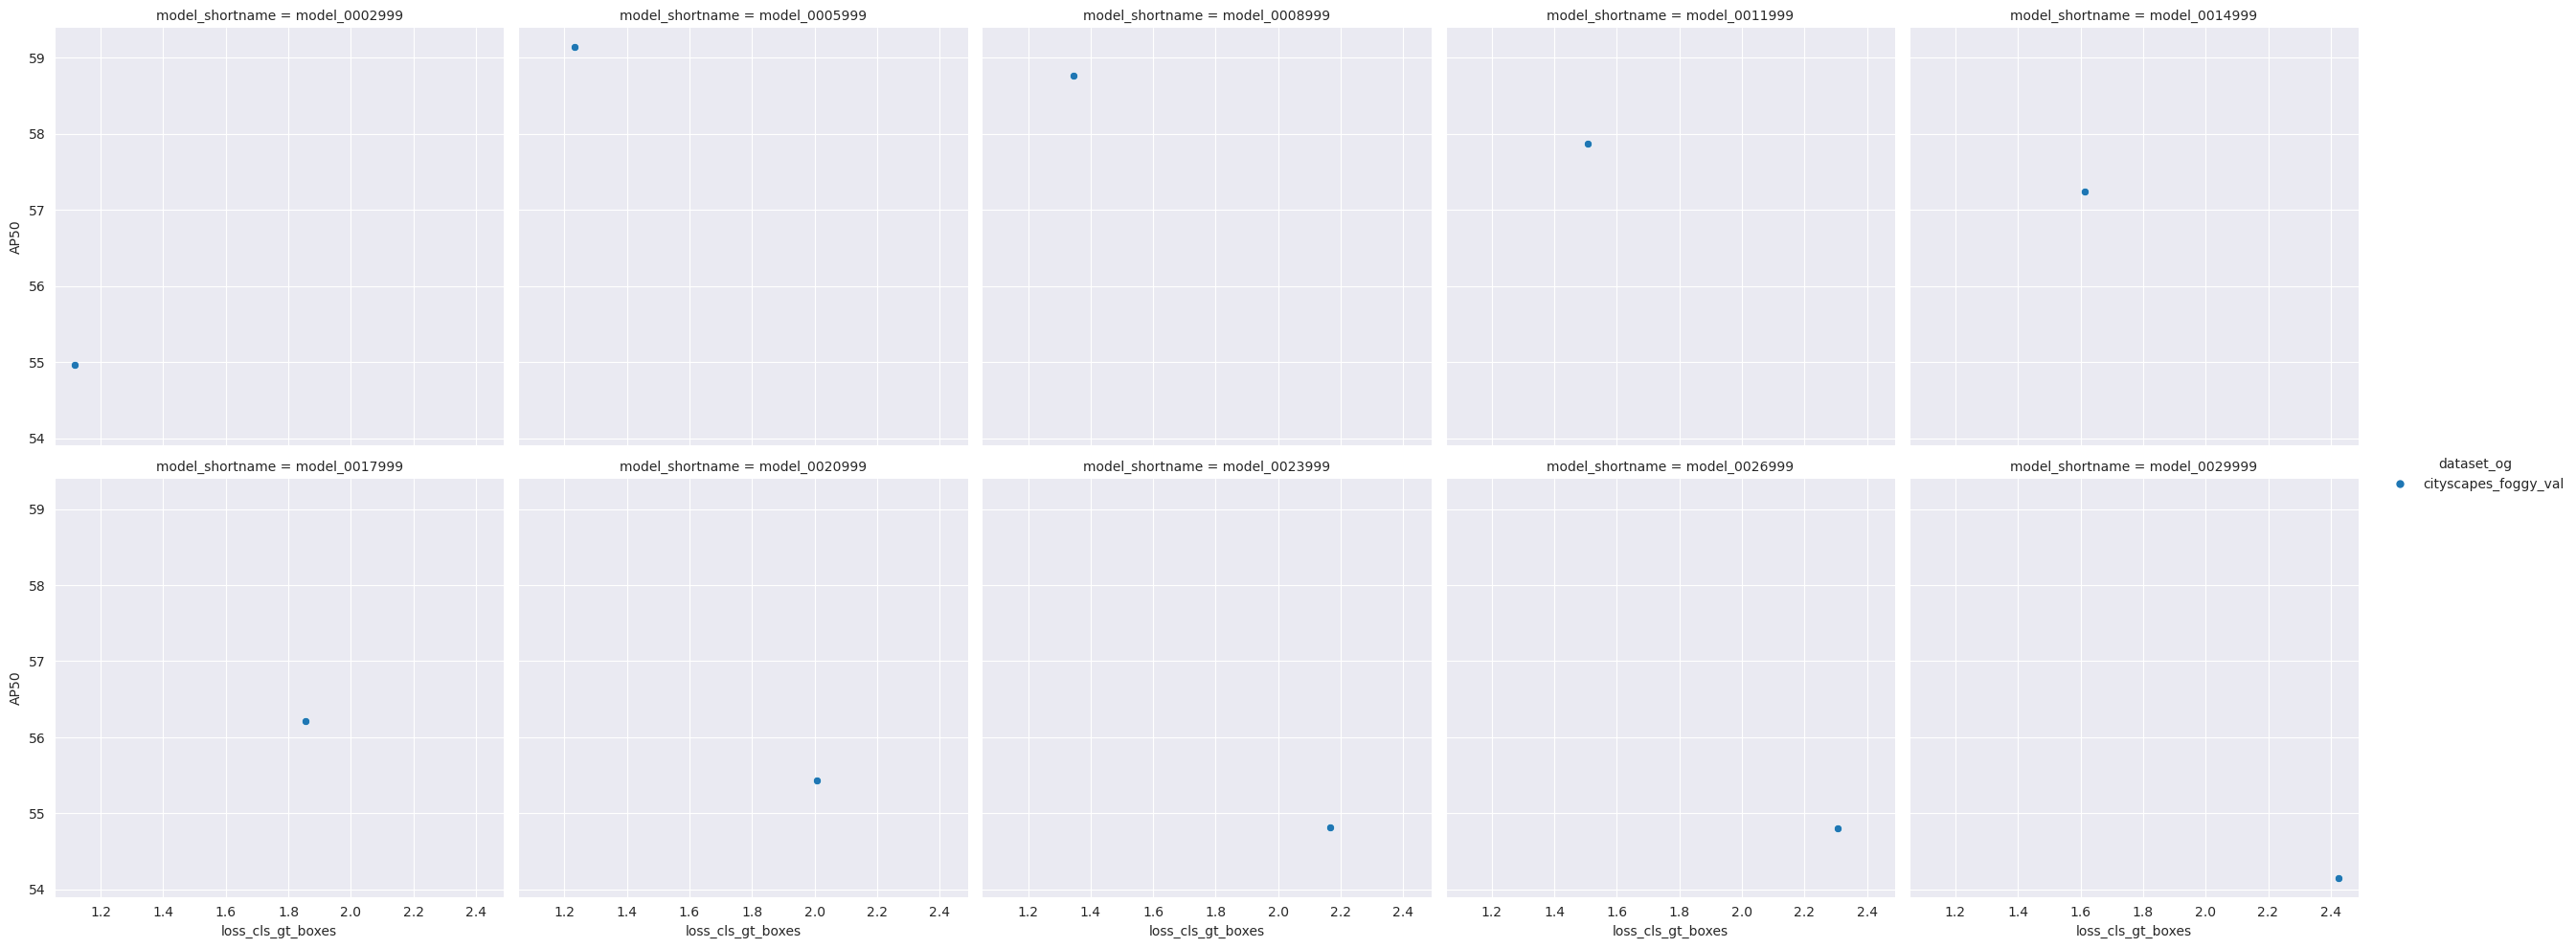

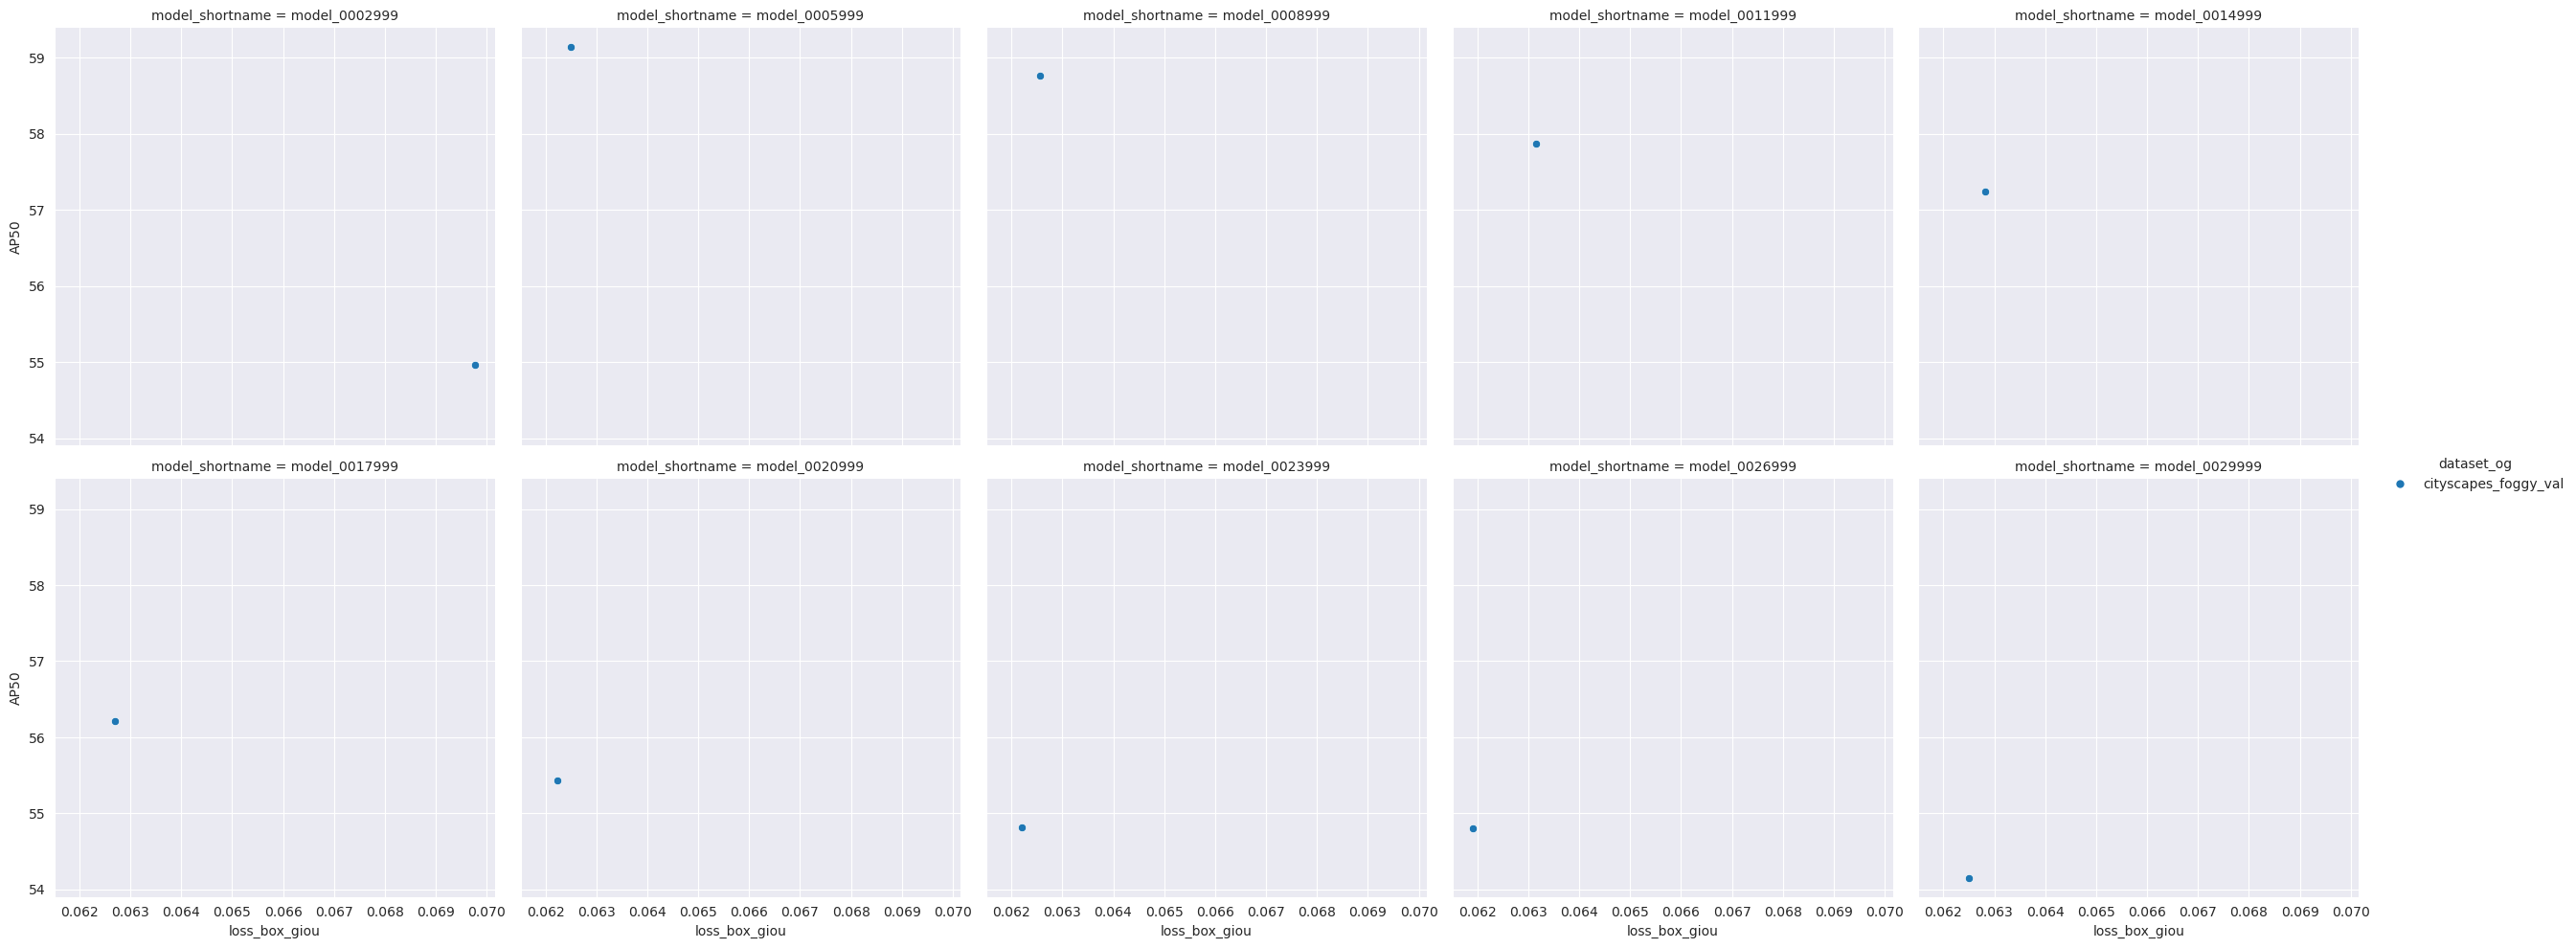

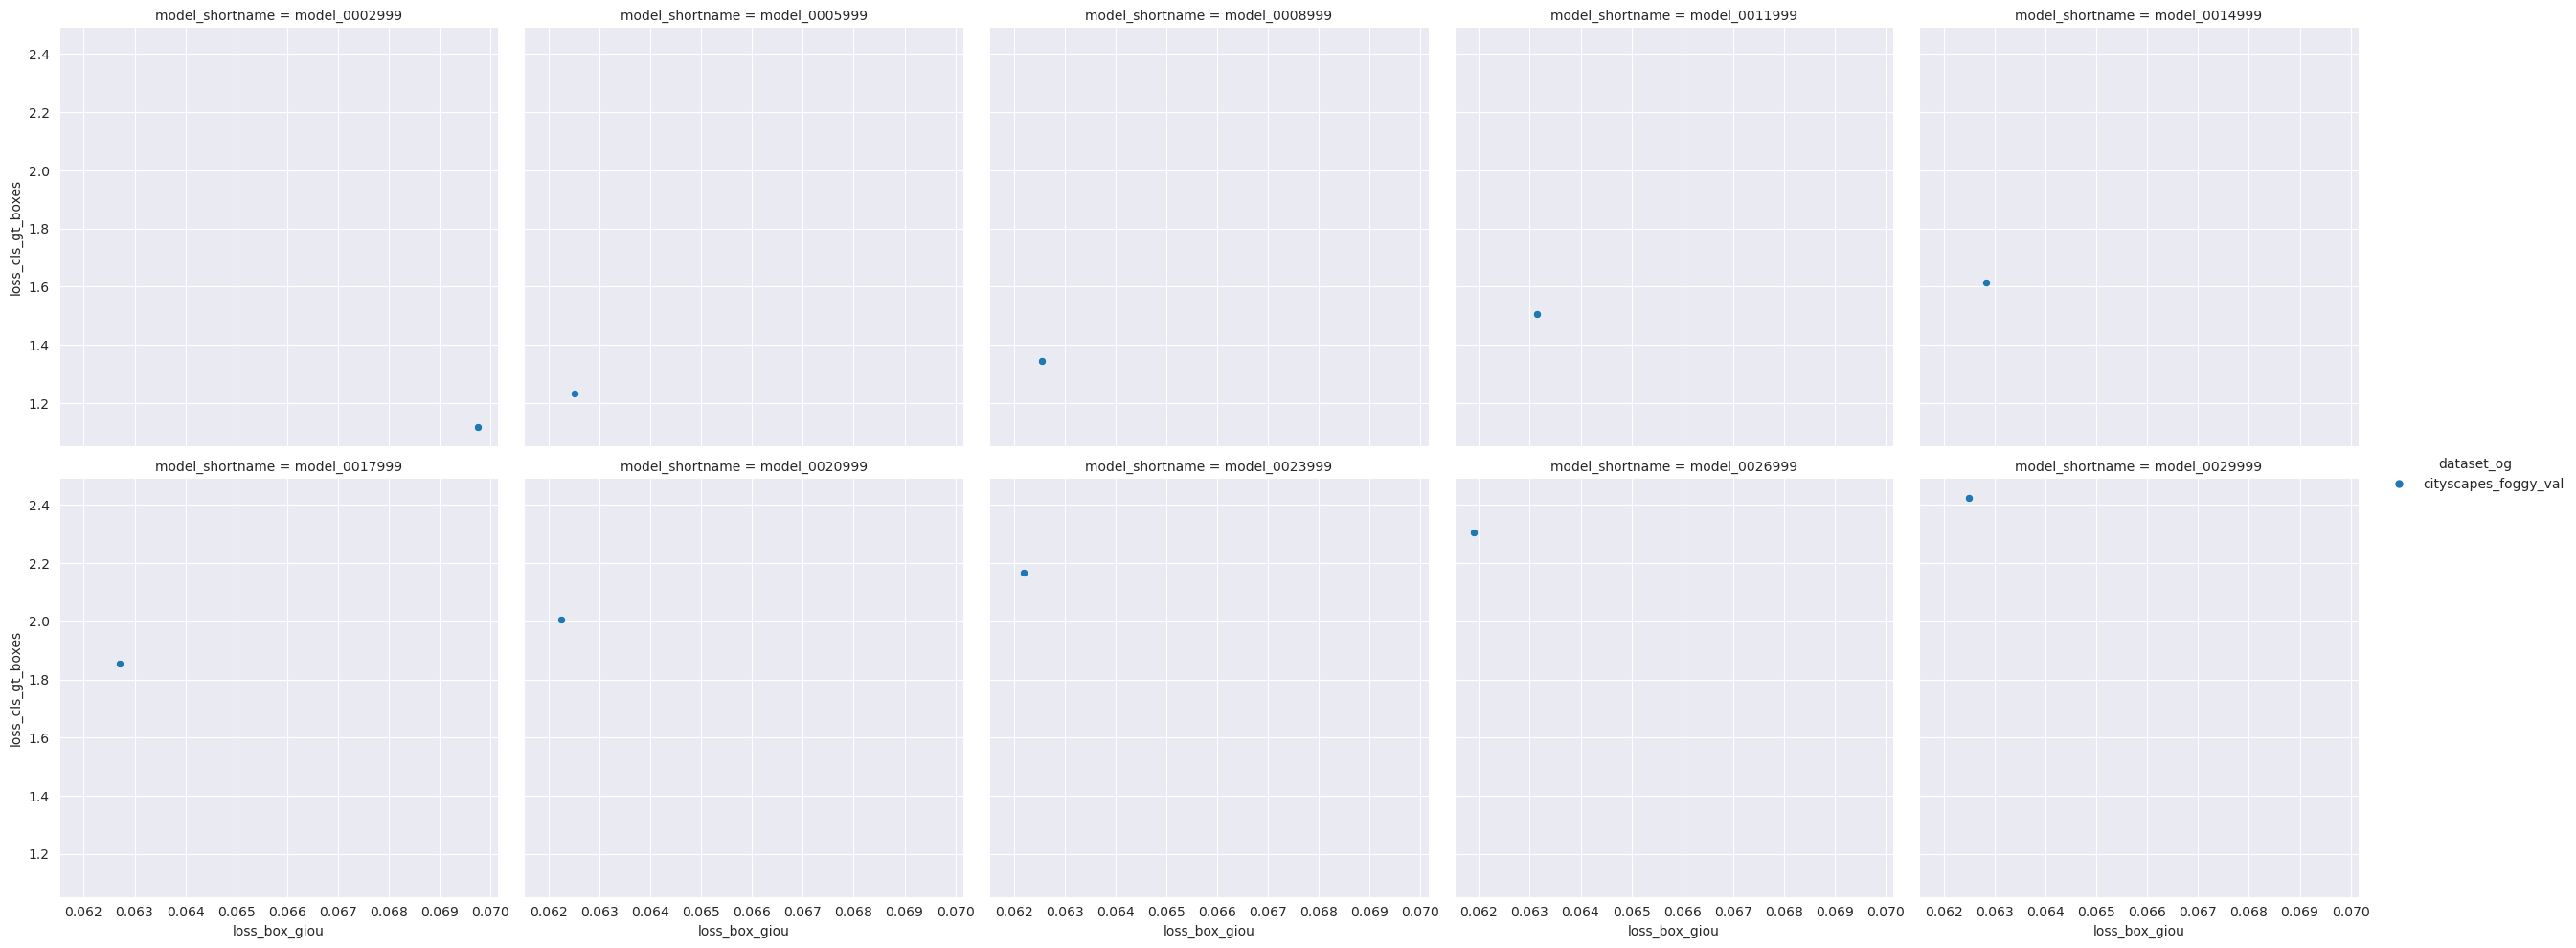

In [23]:

factors =  ['loss_cls_gt_boxes', 'loss_box_smooth_l1', 'loss_box_iou', 'loss_box_giou', 'loss_box_giou_diff', ]
cls_factor = factors[0]
box_factor = factors[3]

factors = [cls_factor, box_factor]
eval = 'AP50'
    
sns.relplot(data=df, x=cls_factor, y=eval, hue='dataset_og', col='model_shortname', kind='scatter', col_wrap=5)
sns.relplot(data=df, x=box_factor, y=eval, hue='dataset_og', col='model_shortname', kind='scatter', col_wrap=5)
sns.relplot(data=df, x=box_factor, y=cls_factor, hue='dataset_og', col='model_shortname', kind='scatter', col_wrap=5)

# Show plot
plt.show()

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

eval_calc = f"{eval}_calc"
df[eval_calc] = 0.0
model_names = sorted(list(set(df['model_shortname'])))
lr_models = {}
for m in model_names:
    model = LinearRegression()
    model_src_data = df.loc[(df['model_shortname']==m) & df['source']].copy()
    model_tgt_data = df.loc[(df['model_shortname']==m) & (df['source'] == False)].copy()
    if len(model_src_data) > 0:
        # fit the model
        X = model_src_data[factors]
        y_src_gt = model_src_data[eval]
        model.fit(X, y_src_gt)
        lr_models[m] = model
        y_src_pred = model.predict(X)
        model_src_data['pred'] = y_src_pred
        
        X_tgt = model_tgt_data[factors]
        y_tgt_gt = model_tgt_data[eval]        
        y_tgt_pred = model.predict(X_tgt)
        model_tgt_data['pred'] = y_tgt_pred
        
        min_y = min([min(y) for y in [y_tgt_pred, y_src_pred]])
        max_y = max([max(y) for y in [y_tgt_pred, y_src_pred]])

        # Visualize predicted vs actual values with different colors
        # Define colors for each category
        colors = {'A': 'blue', 'B': 'green'}
        

        sns.scatterplot(data=model_src_data, x=eval, y='pred', hue='dataset_og')
        sns.scatterplot(data=model_tgt_data, x=eval, y='pred', hue='dataset_og', palette="coolwarm")
        plt.plot([min_y, max_y], [min_y, max_y], '--', c='red', label='Perfect Prediction')
        plt.xlabel(f"Actual {eval}")
        plt.ylabel(f"Predicted {eval}")
        plt.title(f"Model {m} vs. {eval}")
        plt.legend()
        plt.show()
        
        # Residual plots        
        # Fit a multiple linear regression model
        #model2 = smf.ols(f"{eval} ~ {box_factor} + {cls_factor}", data=model_src_data).fit()
        
        # Create a partial regression plot for 'wt'
        #fig, ax = plt.subplots()
        #sm.graphics.plot_partregress(eval, box_factor, [cls_factor], data=model_src_data, ax=ax)
        
        # Show the plot
        #plt.show()

        # Print model details
        print("Intercept:", model.intercept_, "Coefficients:", model.coef_, "R^2 score:", model.score(X, y_src_gt))
        # iterate through dataset
        for dataset in df[df['source']==False]['dataset_og'].unique():
            tgt_condition = (df['model_shortname']==m) & (df['source']==False) & (df['dataset_og']==dataset)
            model_tgt_data = df.loc[tgt_condition]
            out = list(model.predict(model_tgt_data[factors]))
            #print(f" out {out}")
            df.loc[tgt_condition, eval_calc] = out
            mean_eval = df.loc[tgt_condition][[eval]].mean().iloc[0]
            #print(df.loc[(df['model_shortname']==m) & (df['source'] == False)])
            mean_eval_calc = df.loc[tgt_condition][[eval_calc]].mean().iloc[0]
            print(f"Model {m} Dataset {dataset}--Actual {eval}: {mean_eval:.2f}, Predicted: {mean_eval_calc:.2f} Mean squared error: {mean_squared_error(out, model_tgt_data[[eval]]):.2f}")
        

### Summary results


In [25]:
tgt_df = df.loc[df['source']==False]
tgt_df_by_dataset = tgt_df.groupby('dataset_og')

# Iterate through groups
print(f"Eval measure {eval}, prediction factors {factors}")
for dataset, group_df in tgt_df_by_dataset:
    # Group by other columns and calculate the mean of 'AP'
    dataset_summary_df = group_df.groupby(['model_shortname'], as_index=False)[[eval, eval_calc]].mean()
    max_index = dataset_summary_df[eval].idxmax()
    max_eval = dataset_summary_df[eval][max_index]
    min_index = dataset_summary_df[eval].idxmin()
    min_eval = dataset_summary_df[eval][min_index]
    sorted_models = dataset_summary_df['model_shortname'].sort_values(ascending=True)
    last_eval = dataset_summary_df.loc[(dataset_summary_df['model_shortname']==(sorted_models.iloc[-1]))]
    last_eval = last_eval[[eval]].iloc[0,0]
    best_calc_idx = dataset_summary_df[eval_calc].idxmax()
    best_calc = dataset_summary_df[eval][best_calc_idx]
    best_model = dataset_summary_df['model_shortname'][best_calc_idx]
    best_calc_pred = dataset_summary_df[eval_calc][best_calc_idx]
    print(f"Dataset: {dataset}, Best Model: {best_model} - Diff Best: {best_calc-max_eval:.2f}, Diff Last: {best_calc-last_eval:.2f}, Selected {eval}: {best_calc:.2f}, Predicted {eval}: {best_calc_pred:.2f}, Max {eval}: {max_eval:.2f}, Last {eval}: {last_eval:.2f}, Worst: {min_eval:.2f}")


Eval measure AP50, prediction factors ['loss_cls_gt_boxes', 'loss_box_giou']
Dataset: cityscapes_foggy_val, Best Model: model_0002999 - Diff Best: -4.18, Diff Last: 0.81, Selected AP50: 54.96, Predicted AP50: 0.00, Max AP50: 59.14, Last AP50: 54.15, Worst: 54.15


In [26]:
#sns.lmplot(data=df, x=factor, y=eval_calc, hue='domain', col='model_shortname')
results_df = df[['domain', eval, box_factor, cls_factor, 'model_shortname', 'dataset_og']].copy()
results_df['GT'] = 'Yes'

predict_df = df.loc[df['domain']=='target',['domain', eval_calc, box_factor, cls_factor, 'model_shortname', 'dataset_og']].copy()
predict_df['GT'] = 'No'
predict_df.columns = results_df.columns


In [27]:
summary_df = pd.concat([results_df, predict_df], ignore_index=True)
plot_factor = box_factor
# Create a FacetGrid


# Create a FacetGrid
data = results_df[results_df['domain']=='source']
g = sns.relplot(data=data, x=plot_factor, y=eval, hue='dataset_og', col='model_shortname', col_wrap=4)


# Add scatter plot and linear regression line to each facet
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the region
    mod_name = ax.get_title().split(' = ')[1]
    
    # select the data for the region
    data = predict_df[predict_df.model_shortname.eq(mod_name)]
    data = data[(data['domain']=='target') & (data['GT'] == 'No')]
    sns.scatterplot(data=data, x=plot_factor, y=eval, ax=ax, hue='dataset_og', palette="coolwarm")
    




KeyError: 'model_shortname'